In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator

plt.style.use('fivethirtyeight')
%matplotlib inline 

In [2]:
confirmed_df = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [3]:
cols = confirmed_df.keys()

In [4]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [5]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())

In [6]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)


days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [7]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [8]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []

# convert integer into datetime for better visualisation
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [9]:
# split data into training set and testing set
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.05, shuffle=False)

### Model selection

In [10]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=8, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 5525.274087767801
MSE: 55236073.425823845


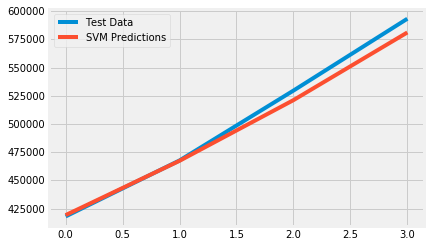

In [11]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [12]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=6)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [13]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 3589.092988553457
MSE: 13914835.234761763


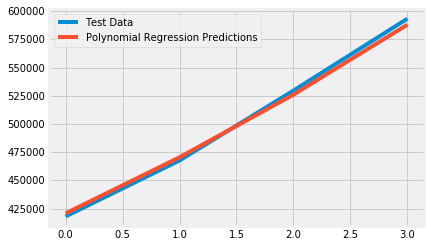

In [14]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [15]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.5s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e

In [16]:
bayesian_search.best_params_

{'tol': 0.0001,
 'lambda_2': 0.0001,
 'lambda_1': 1e-07,
 'alpha_2': 1e-07,
 'alpha_1': 0.0001}

In [17]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 71754.98097843016
MSE: 5791040968.971269


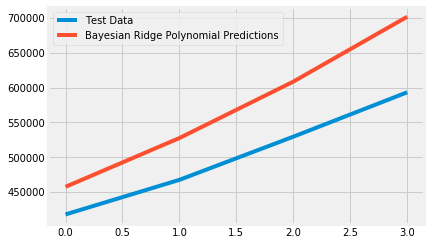

In [18]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

### Visualisation

Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

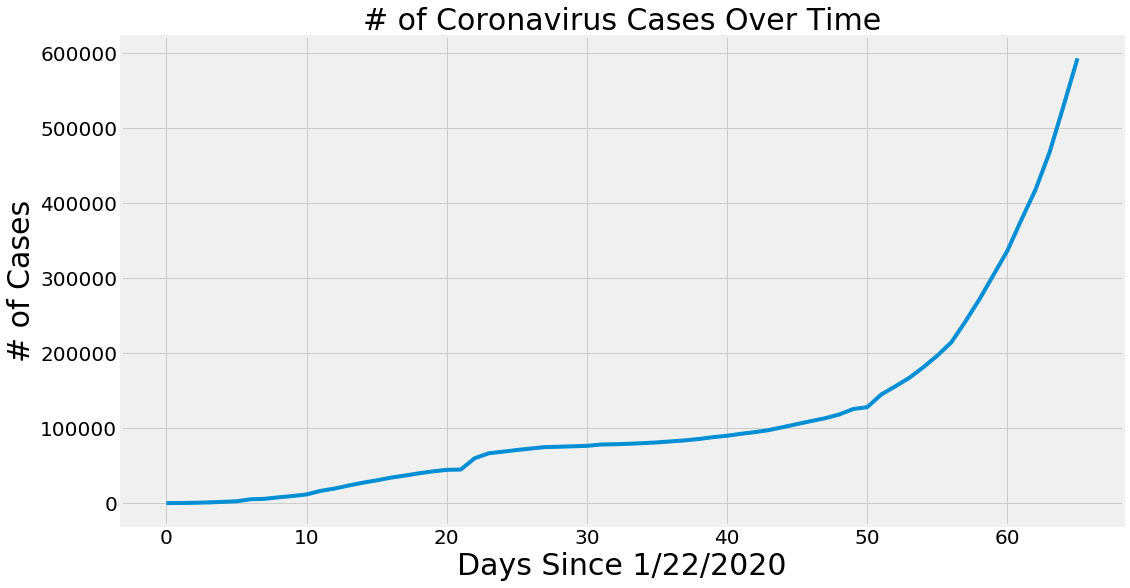

In [19]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

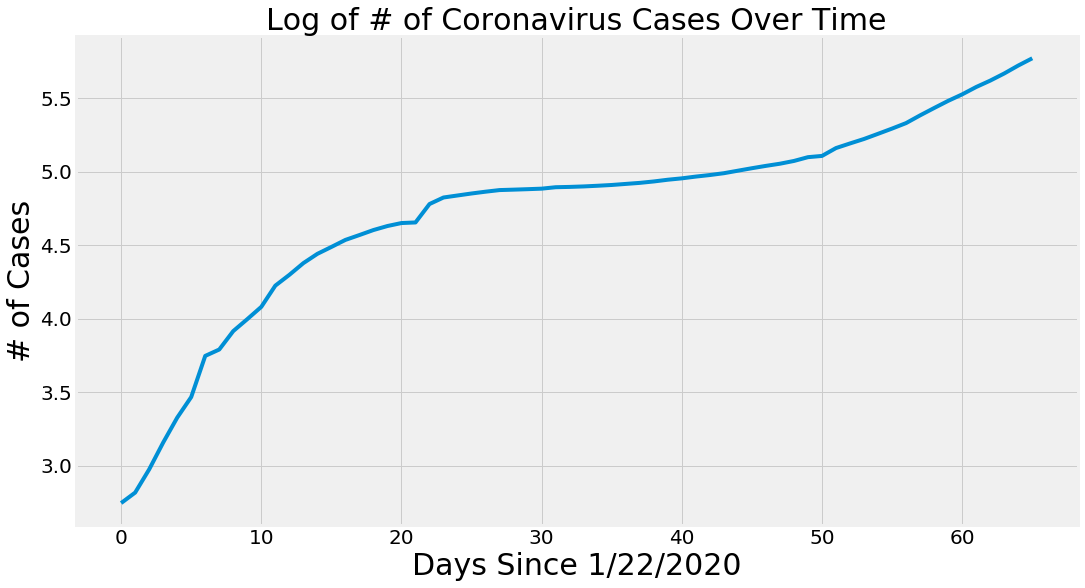

In [20]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

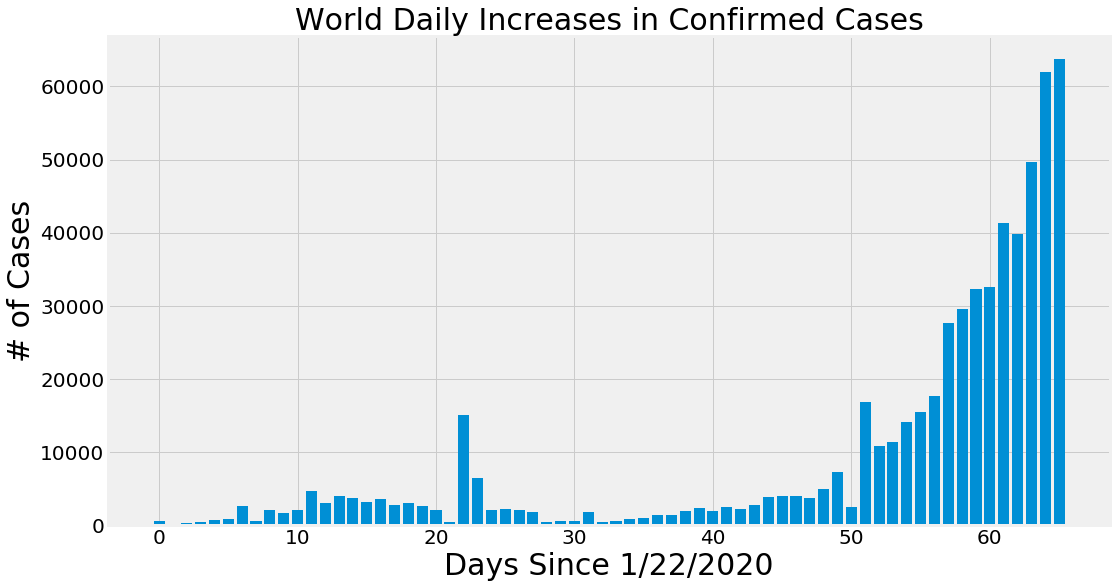

In [21]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

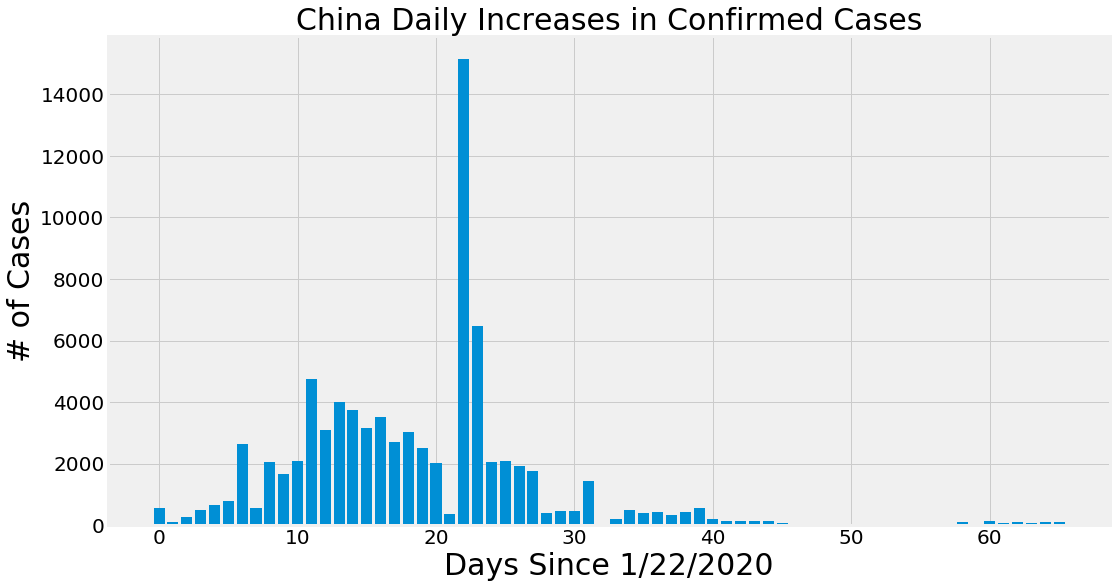

In [22]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, china_daily_increase)
plt.title('China Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

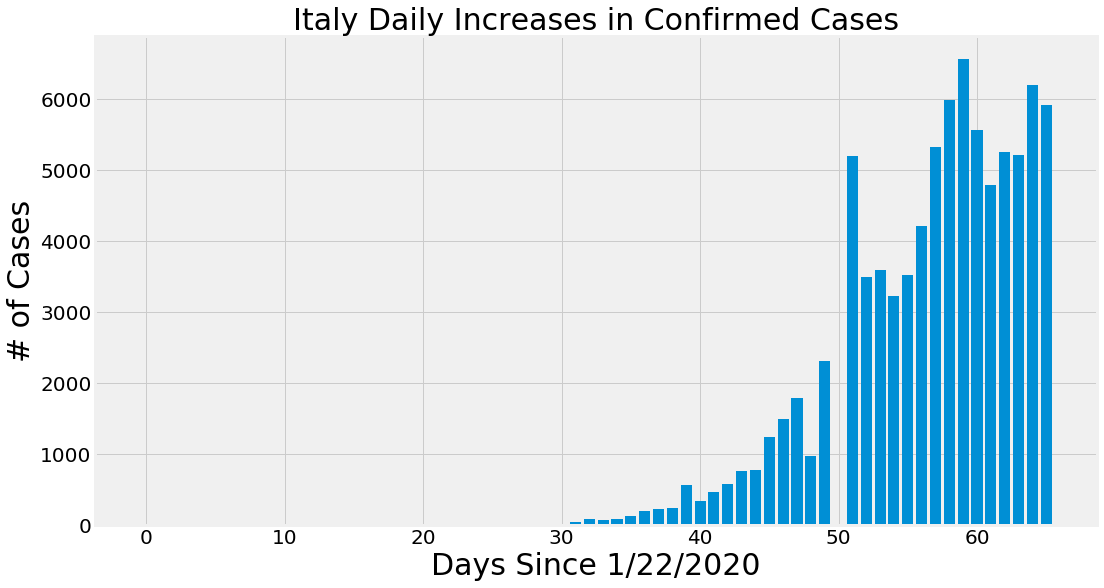

In [23]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_increase)
plt.title('Italy Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

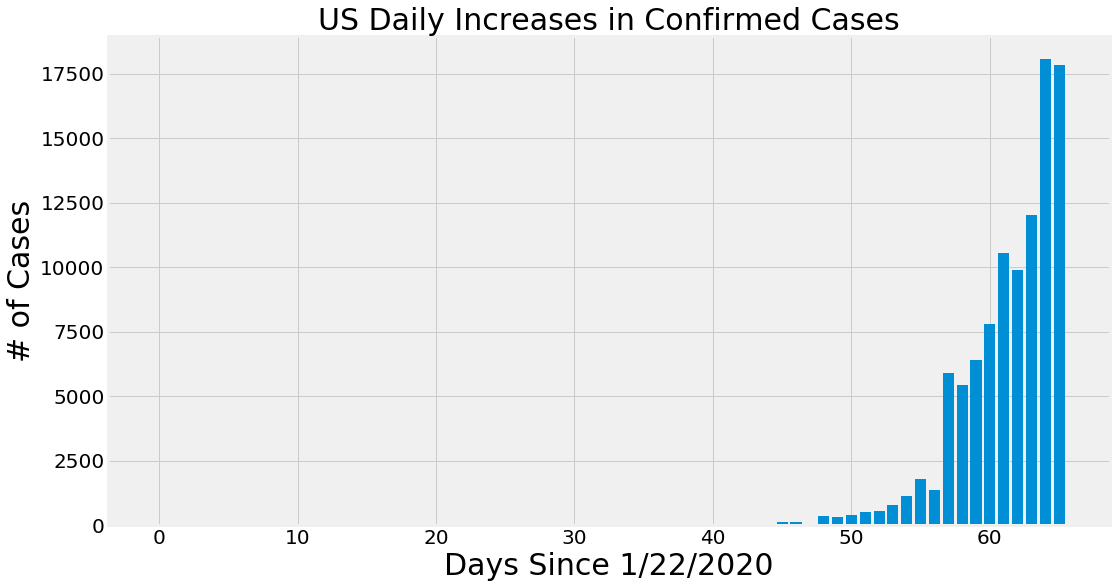

In [24]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_increase)
plt.title('US Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

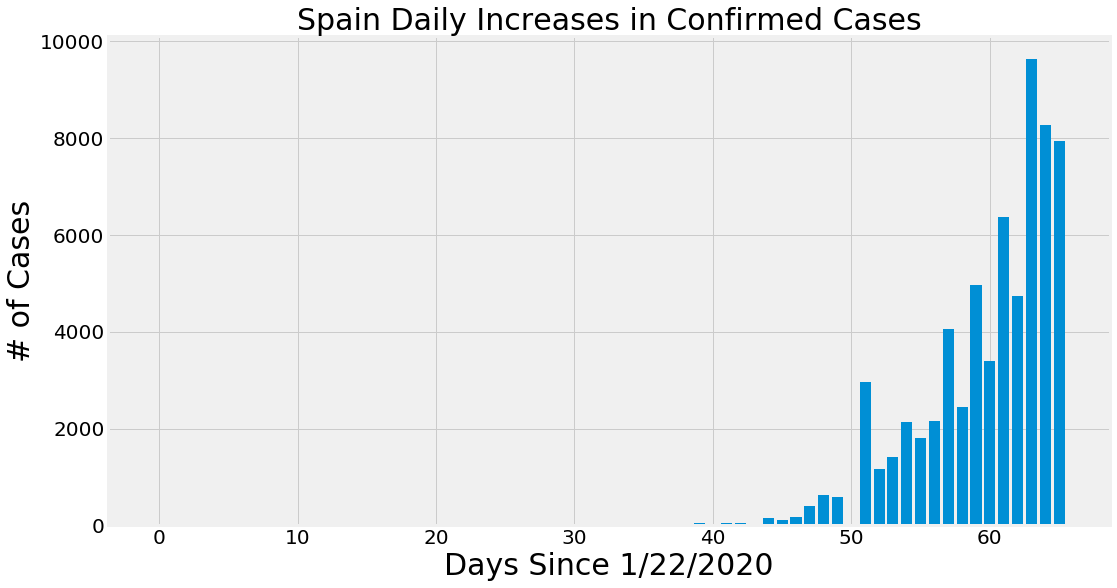

In [25]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, spain_daily_increase)
plt.title('Spain Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

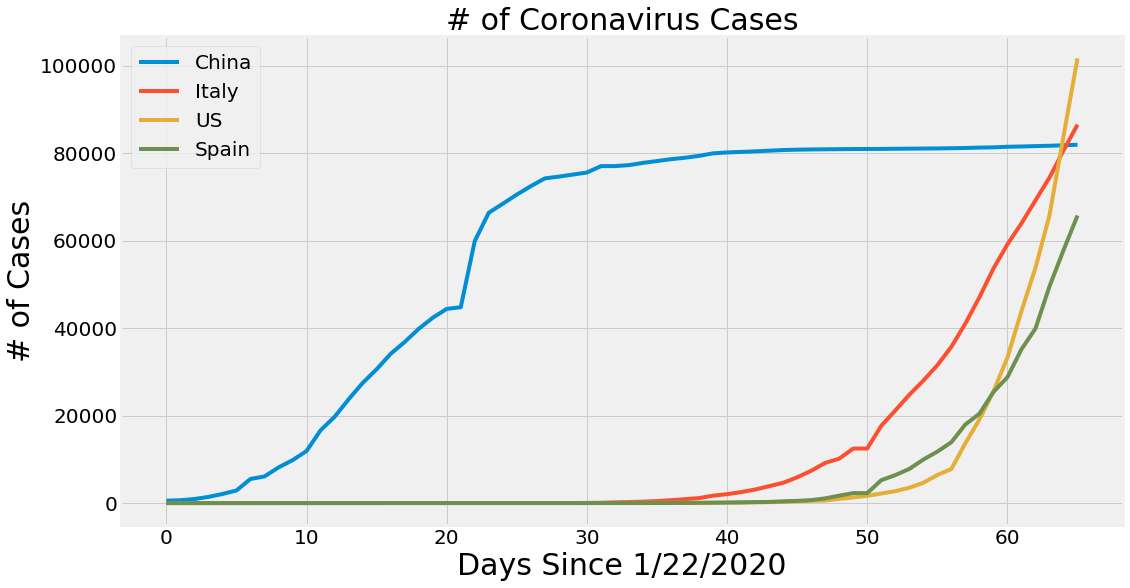

In [26]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

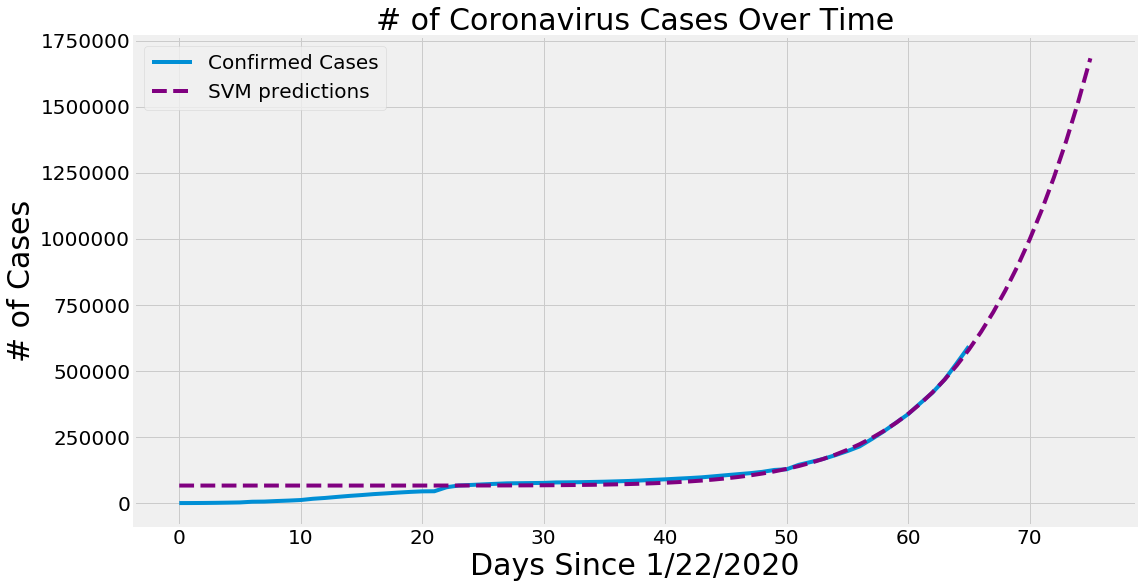

In [27]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

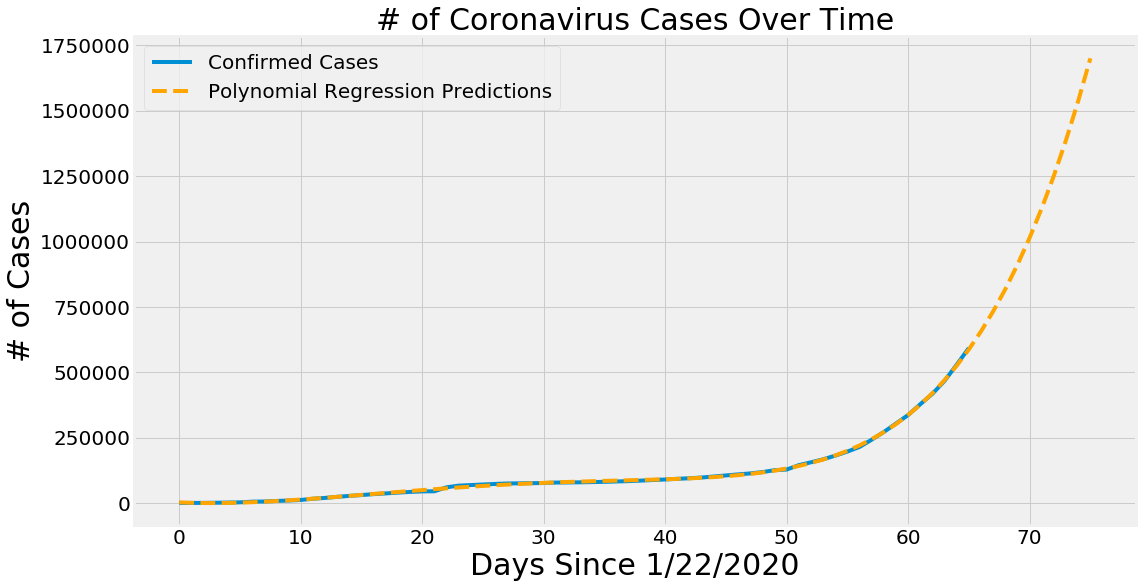

In [28]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

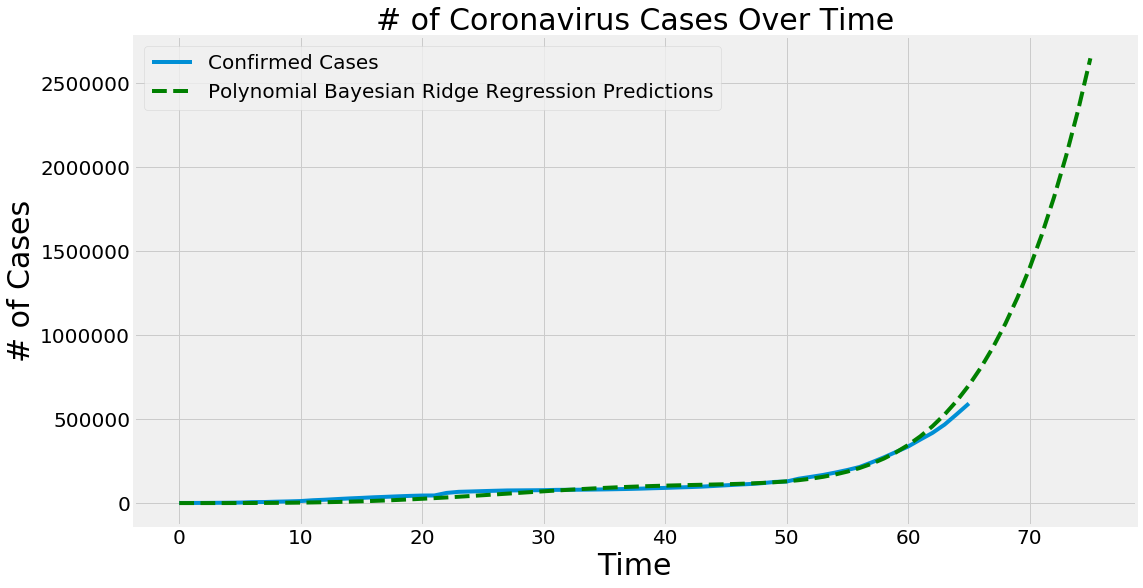

In [29]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Future predictions

In [30]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('03/28/2020', 647952.0),
 ('03/29/2020', 722249.0),
 ('03/30/2020', 804728.0),
 ('03/31/2020', 896149.0),
 ('04/01/2020', 997331.0),
 ('04/02/2020', 1109152.0),
 ('04/03/2020', 1232560.0),
 ('04/04/2020', 1368567.0),
 ('04/05/2020', 1518260.0),
 ('04/06/2020', 1682804.0)}

In [31]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('03/28/2020', 656986.0),
 ('03/29/2020', 733501.0),
 ('03/30/2020', 818200.0),
 ('03/31/2020', 911746.0),
 ('04/01/2020', 1014841.0),
 ('04/02/2020', 1128226.0),
 ('04/03/2020', 1252682.0),
 ('04/04/2020', 1389035.0),
 ('04/05/2020', 1538155.0),
 ('04/06/2020', 1700958.0)}

In [32]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('03/28/2020', 808367.0),
 ('03/29/2020', 929977.0),
 ('03/30/2020', 1068085.0),
 ('03/31/2020', 1224337.0),
 ('04/01/2020', 1400489.0),
 ('04/02/2020', 1598416.0),
 ('04/03/2020', 1820113.0),
 ('04/04/2020', 2067701.0),
 ('04/05/2020', 2343434.0),
 ('04/06/2020', 2649699.0)}

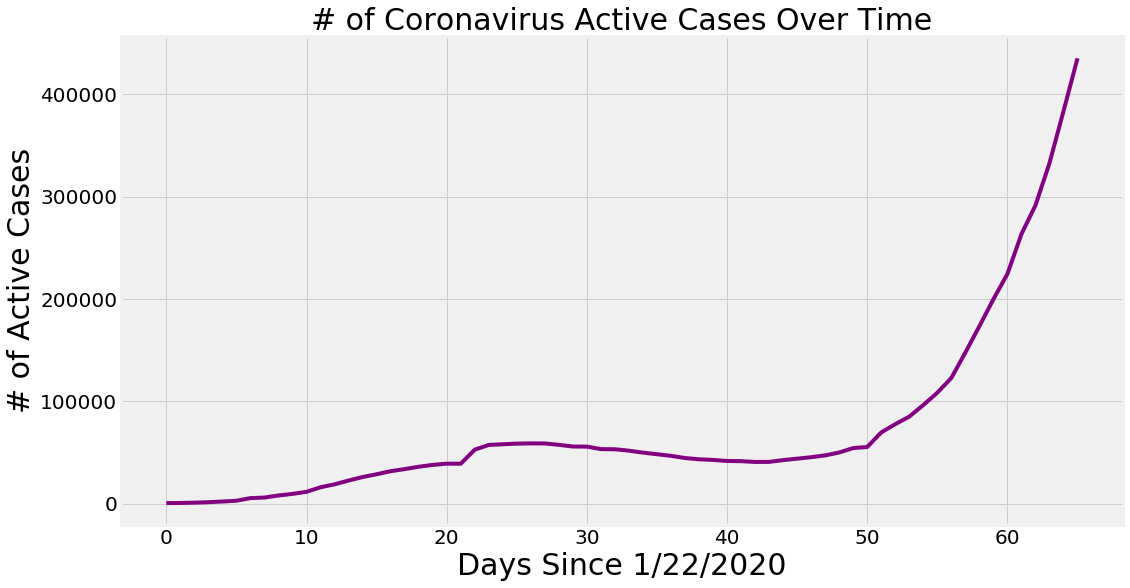

In [33]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active, color='purple')
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

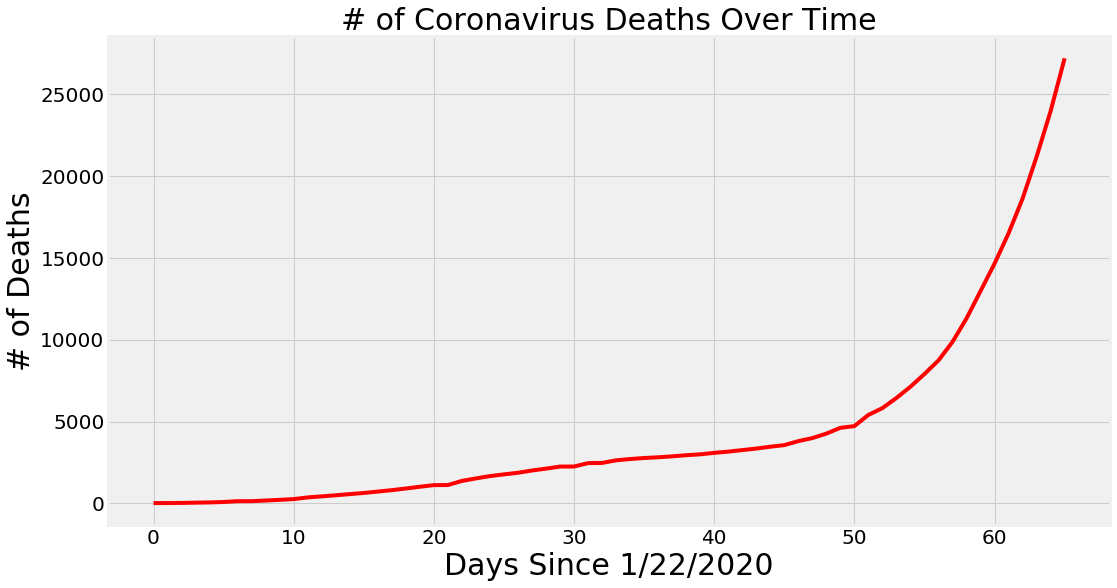

In [34]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

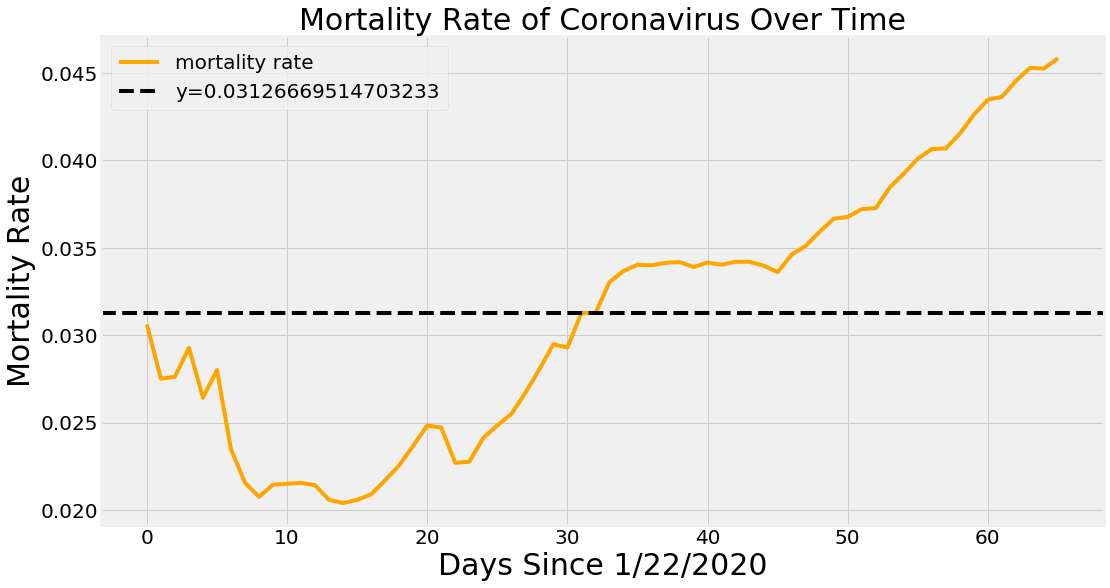

In [35]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

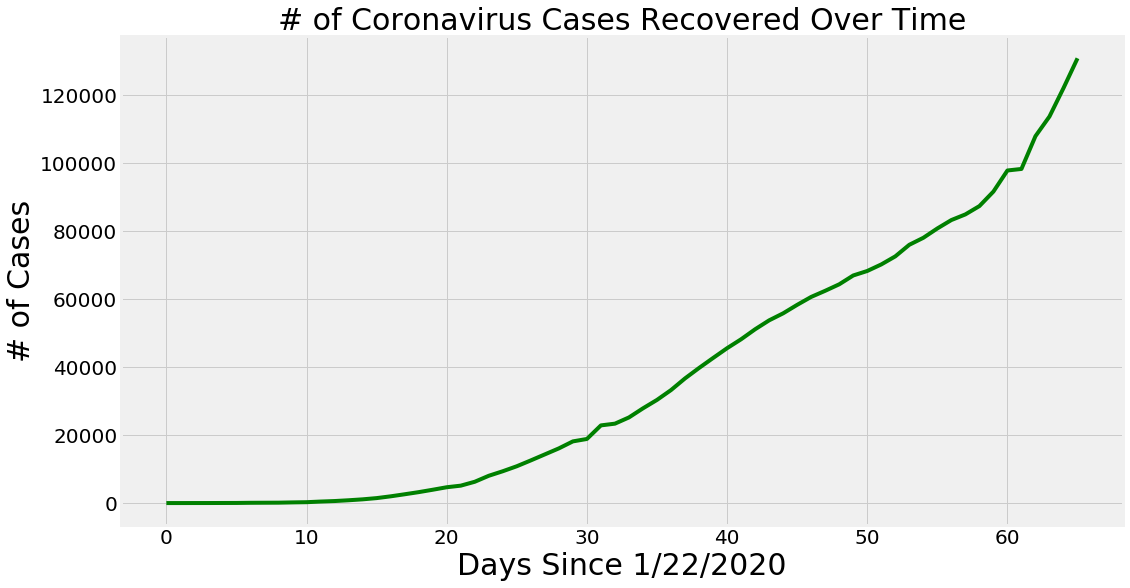

In [36]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

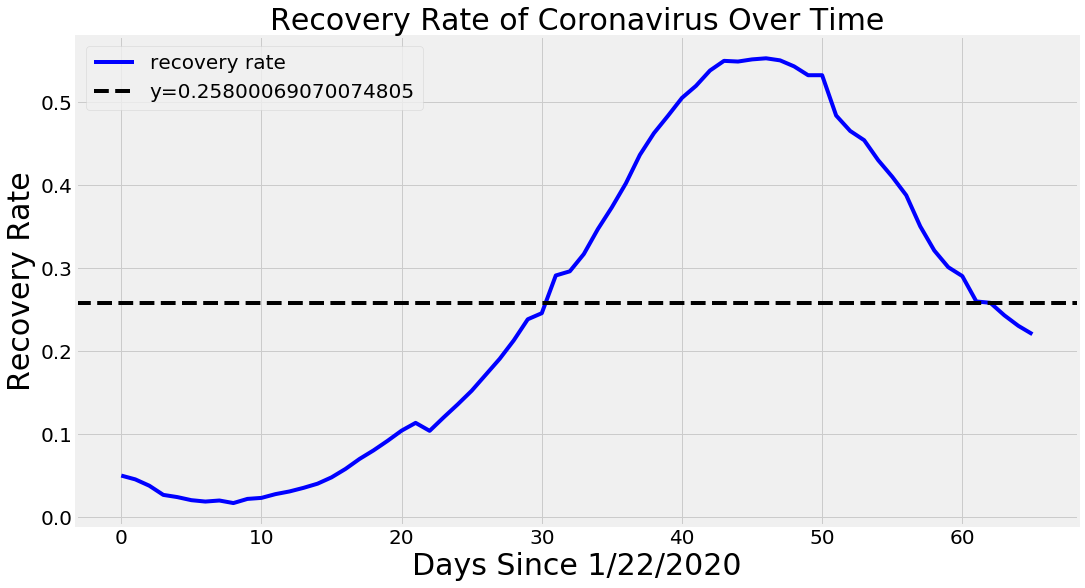

In [37]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

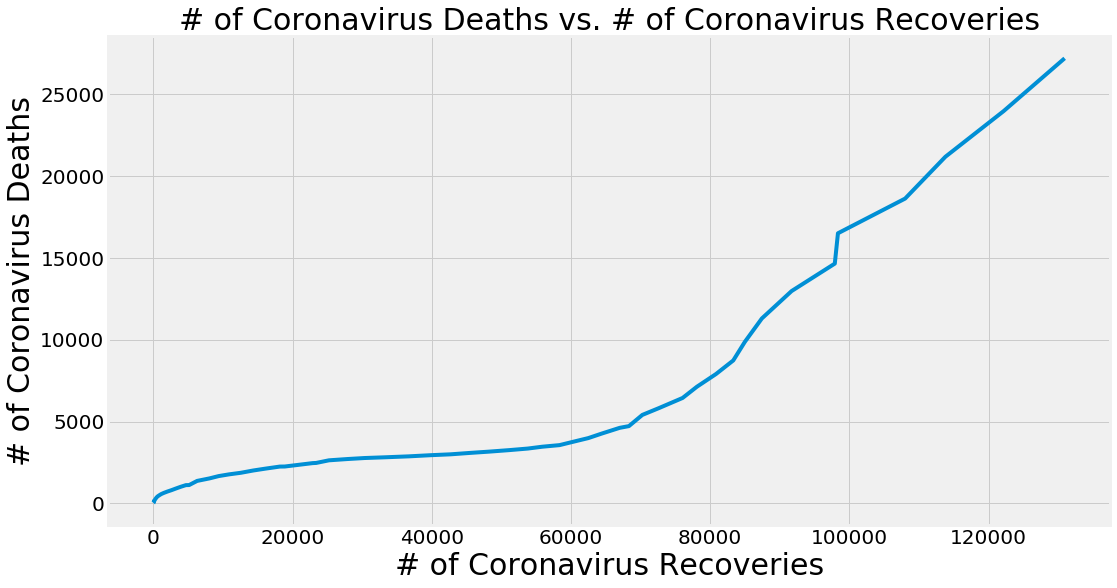

In [38]:
plt.figure(figsize=(16, 9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [39]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [41]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]

country_confirmed_cases = []
no_cases = []

for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region']==unique_countries[i]].sum()

In [42]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Countries/Regions:
US: 101657 cases
Italy: 86498 cases
China: 81897 cases
Spain: 65719 cases
Germany: 50871 cases
France: 33402 cases
Iran: 32332 cases
United Kingdom: 14745 cases
Switzerland: 12928 cases
Korea, South: 9332 cases
Netherlands: 8647 cases
Austria: 7657 cases
Belgium: 7284 cases
Turkey: 5698 cases
Canada: 4682 cases
Portugal: 4268 cases
Norway: 3755 cases
Brazil: 3417 cases
Australia: 3143 cases
Sweden: 3069 cases
Israel: 3035 cases
Czechia: 2279 cases
Denmark: 2200 cases
Malaysia: 2161 cases
Ireland: 2121 cases
Chile: 1610 cases
Luxembourg: 1605 cases
Ecuador: 1595 cases
Japan: 1468 cases
Poland: 1389 cases
Pakistan: 1373 cases
Romania: 1292 cases
South Africa: 1170 cases
Thailand: 1136 cases
Saudi Arabia: 1104 cases
Indonesia: 1046 cases
Finland: 1041 cases
Russia: 1036 cases
Greece: 966 cases
Iceland: 890 cases
India: 887 cases
Philippines: 803 cases
Singapore: 732 cases
Diamond Princess: 712 cases
Panama: 674 cases
Peru: 635 cases
Slovenia: 632 case